In [1]:
#load modules
print('loading modules...')
import numpy as np

#import cmb
import healpy as hp
import pymaster as nmt
import matplotlib.pyplot as plt

import camb
import pymaster as nmt

loading modules...


In [2]:
#Define a function to get the theory Cl
print('setting parameters...')
nside = 1024
lmax = 3*nside-1
lmax_len = 3*nside-1 # desired lmax of the lensed field.
dlmax = 3*nside-1   # lmax of the unlensed fields is lmax + dlmax.  (some buffer is required for accurate lensing at lmax)
epsilon = 1e-6  # target accuracy of the output maps (execution time has a fairly weak dependence on this)
lmax_unl, mmax_unl = lmax_len + dlmax  , lmax_len + dlmax 
if nside == 2048 or nside == 4096:
    lmax_unl, mmax_unl = 10000  , 10000
Tcmb = 2.7255e6

setting parameters...


## Firstly, you need to get theory Cl.

In [3]:
#Define a function to get the theory Cl
def get_CAMB_cl(As=2.119631e-9, r=1, H0=67.01904, ns=0.9636852):

    pars = camb.CAMBparams()

    pars = camb.set_params(H0=H0, ombh2=0.02216571, omch2=0.1202944, mnu=0.0006451439, omk=0, tau=0.06018107, YHe=0.2453006, num_nu_massless=2.03066666667, nu_mass_eigenstates = 1,\
                        num_nu_massive=1, share_delta_neff=False, nu_mass_degeneracies = [1.01533333333],nu_mass_fractions = [1], Alens = 1.00000000000000,\
                        w=-1.0, wa=0, nnu=3.046, nt=-r/8.0, nrun=0, pivot_scalar=0.05, pivot_tensor=0.05, TCMB = 2.7255 )

    pars.WantTensors = True
    pars.InitPower.set_params(As=As, ns=ns, r=r)
    pars.set_for_lmax(lmax_unl, lens_potential_accuracy=8)

    #calculate results for these parameters
    results = camb.get_results(pars)

    unlensed_total = results.get_unlensed_total_cls(raw_cl=False) * Tcmb**2 # unlensed CMB power spectra, including tensors
    return unlensed_total

## Define a function to draw theory values, which will be transported to likelihood function.

In [4]:
def get_binned(nside,nbl,cl,lmax=0):   
    """
    Bins the input Cl.
    """
    if lmax != 0:
        bin1 = nmt.NmtBin.from_lmax_linear(lmax, nbl)
    else: 
        bin1 = nmt.NmtBin.from_nside_linear(nside, nbl)


    cl_tt_binned = bin1.bin_cell(np.array([cl]))


    ell_eff = bin1.get_effective_ells()

    return ell_eff,cl_tt_binned[0]

### Get you observed data here.

In [5]:
dlbb_LT_LT_average = np.loadtxt('./post_cal/LT_LT_mean.txt')  #l_bin, dlbb_temp_noisy, dlbb_temp_noise, dlbb_pure, dlbb_temp_cross_bias, transfer_temp

dlbb_LT_obs_average = np.loadtxt('./post_cal/LT_obs_mean.txt')   #l_bin, dlbb_cross, dlbb_cross_pure, dlbb_cross_noise1, dlbb_cross_noise2, transfer_temp_cross

dlbb_obs_obs_average = np.loadtxt('./post_cal/obs_mean.txt')    # l_bin, dlbb_obs, dlbb_noise

############ Fiducial cls ############
dlbb_len = dlbb_LT_LT_average[3]/dlbb_LT_LT_average[6]

dlbb_obs = dlbb_obs_obs_average[1]

dlbb_noise = dlbb_obs - dlbb_len


dlbb_ten_1_raw = get_CAMB_cl( r=1, )[:,2]
_,dlbb_ten_1 =  get_binned(nside,40,dlbb_ten_1_raw[:501],lmax=500)


############ data cls #############

data_vec = np.loadtxt('./post_cal/data_vec_fit_average_old.txt')

############ sim COVMAT ############

COV_sim = np.load('./post_cal/cov_blocks.npy',allow_pickle=True).item()

### We redefine the theory calculator here (a personal preference)

In [6]:
def get_cl(r, AL,  LMAX=10):
    """
    Returns the theory Cl vector for a given r and AL.
    """
    return [r*dlbb_ten_1[:LMAX] + AL*dlbb_len[:LMAX] + dlbb_noise[:LMAX], (AL)*dlbb_len[:LMAX], AL*dlbb_len[:LMAX]]



def split_th_vec(th_vec):
    return {
        (0,0): th_vec[0],
        (0,1): th_vec[1], (1,1): th_vec[2],
        }

In [7]:
from HL_likelihood import *

loading modules...
loading modules...


# Before run MCMC, we first check the data.

In [13]:
from copy import deepcopy

def covmat_condition(cov_input, ell_flag='full', map_flag='full'):
    """
    Conditioning the covariance matrix blocks based on ell and map flags.

    """
    cov = deepcopy(cov_input)
    keys = list(cov.keys())
    N_ell = int(len(cov)**0.5)  # Assuming keys are of the form "(i,j)" where i and j are ell bins

    sample_block = cov[next(iter(cov))]
    N_comp = sample_block.shape[0]

    for i in range(N_ell):
        for j in range(N_ell):
            key = f"({i},{j})"
            if key not in cov:
                continue

            block = cov[key]

            # --- ell-bin consitionging ---
            if ell_flag == 'diag' and i != j:
                cov[key][:] = 0
                continue
            if ell_flag == 'nearest' and abs(i - j) > 1:
                cov[key][:] = 0
                continue
            # ell_flag=='full' => keep all blocks

            # --- map conditioning ---
            if map_flag == 'diag':
                for l in range(N_comp):
                    for m in range(N_comp):
                        if l != m:
                            block[l, m] = 0
            elif map_flag == 'nearest':
                for l in range(N_comp):
                    for m in range(N_comp):
                        if abs(l - m) > 1:
                            block[l, m] = 0
            # map_flag=='full' => keep the entire block

            cov[key] = block

    return cov
import numpy as np

def cov_dict_inverse(cov_dict, HA_factor):
    """
    Computes the inverse of a covariance matrix represented as a dictionary of blocks.
    """
    # Acquire all  bins
    bins = sorted(set([int(k.split(',')[0][1:]) for k in cov_dict.keys()] +
                      [int(k.split(',')[1][:-1]) for k in cov_dict.keys()]))
    Nbins = len(bins)
    Ncomp = next(iter(cov_dict.values())).shape[0]  # the dimension of each block

    # Construct the full large matrix
    big_N = Nbins * Ncomp
    big_cov = np.zeros((big_N, big_N), dtype=np.float64)

    for key, block in cov_dict.items():
        i, j = [int(x) for x in key[1:-1].split(',')]
        big_cov[i*Ncomp:(i+1)*Ncomp, j*Ncomp:(j+1)*Ncomp] = block

    # Check if positive definite, otherwise use pseudo-inverse
    try:
        big_cov_inv = np.linalg.inv(big_cov)
    except np.linalg.LinAlgError:
        print("Warning: full covariance matrix is singular, using pseudo-inverse.")
        big_cov_inv = np.linalg.pinv(big_cov)

    # Decompose back into dictionary
    cov_inv_dict = {}
    for i in bins:
        for j in bins:
            block_inv = big_cov_inv[i*Ncomp:(i+1)*Ncomp, j*Ncomp:(j+1)*Ncomp]
            cov_inv_dict[f"({i},{j})"] = block_inv * HA_factor

    return cov_inv_dict


cov_condition = covmat_condition(COV_sim, ell_flag='full', map_flag='full')



Nsim = 498
nblock = 3
nL = 7
p = nblock * nL
HA_factor = (Nsim - p - 2)/(Nsim - 1)

HA_factor = 1

COV_INV = cov_dict_inverse(cov_condition, HA_factor)

In [11]:
CORR_sim = np.load('./post_cal/corr_blocks.npy',allow_pickle=True).item()

💾 Saved to Correlation_matrix.pdf


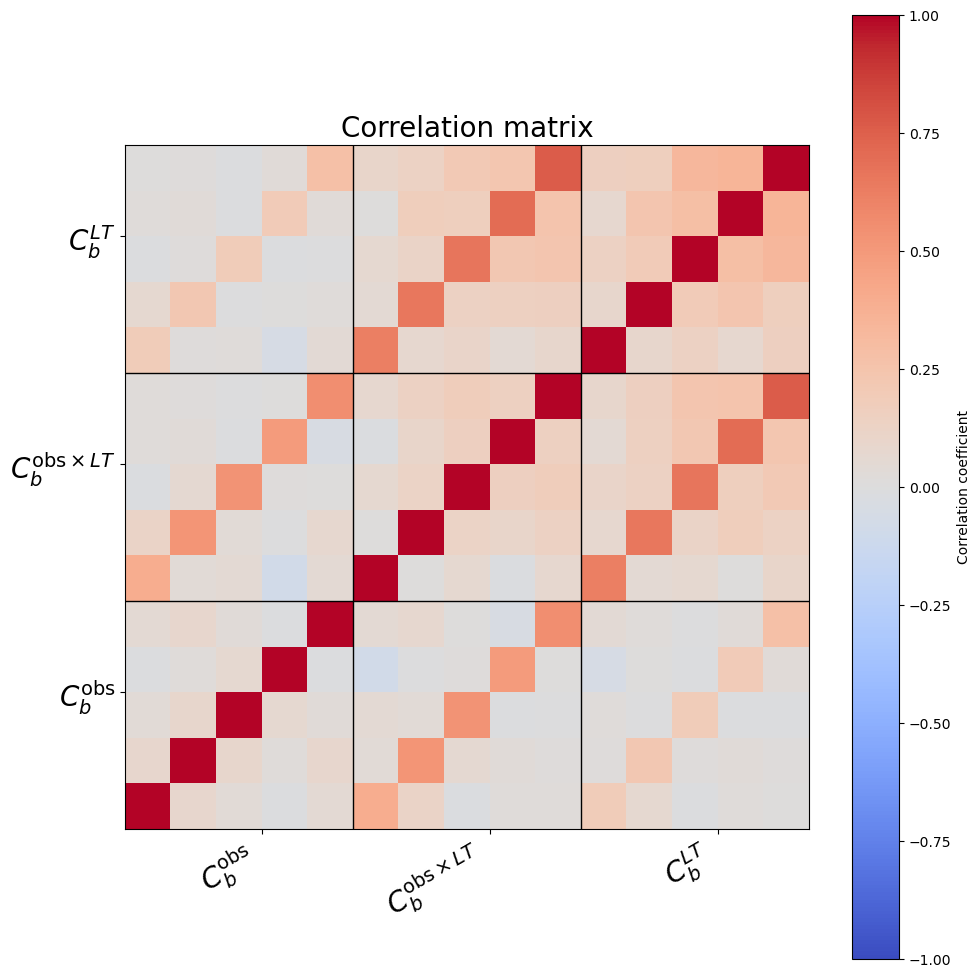

array([[ 1.00000000e+00,  8.41431834e-02,  3.34081685e-02,
        -1.35633538e-02,  5.21900555e-02,  3.96470605e-01,
         1.11986814e-01, -2.02423913e-02,  1.92422177e-02,
         1.66779731e-02,  1.82017692e-01,  6.82745465e-02,
        -1.10388685e-02,  2.03813240e-02,  6.56301590e-03],
       [ 8.41431834e-02,  1.00000000e+00,  8.75531863e-02,
         2.03454640e-02,  8.11433567e-02,  3.36426743e-02,
         5.19933055e-01,  6.10680739e-02,  2.68091148e-02,
         9.64191958e-03,  1.21826578e-02,  2.25314210e-01,
         1.55402767e-02,  2.67918877e-02,  9.87160899e-03],
       [ 3.34081685e-02,  8.75531863e-02,  1.00000000e+00,
         6.32253494e-02,  2.73804170e-02,  5.43366196e-02,
         3.80511992e-02,  5.31097178e-01, -8.56511243e-03,
        -2.30690579e-03,  1.97473347e-02, -7.26257999e-04,
         1.79700044e-01, -1.51175511e-02, -8.55844823e-03],
       [-1.35633538e-02,  2.03454640e-02,  6.32253494e-02,
         1.00000000e+00, -1.04574699e-02, -8.05536173

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_covmat_component_blocks(COV, ncomp=3, lmax=5, block_labels=None,
                                 save_path=None, cmap='coolwarm', vmin=-1, vmax=1):
    """
    Plot correlation matrix with each block representing one component (e.g., TT, TE, EE).

    Parameters
    ----------
    COV : dict[str, np.ndarray] or np.ndarray
        Covariance dictionary (key like '(i,j)') or full covariance matrix.
        Each (i,j) corresponds to covariance between ell-bin i and j (each with ncomp entries).
    ncomp : int
        Number of components per ell-bin (e.g., 3 for TT, TE, EE).
    lmax : int
        Number of ell bins.
    block_labels : list[str]
        Names of components, e.g. ["TT","TE","EE"].
    save_path : str or None
        Path to save the figure.
    cmap, vmin, vmax : 
        Colormap options.
    """

    # --- Step 1: If input is a dictionary, assemble the full matrix ---
    if isinstance(COV, dict):
        N = ncomp * lmax
        cov_full = np.zeros((N, N))
        for key, block in COV.items():
            i, j = map(int, key.strip("()").split(","))
            cov_full[i*ncomp:(i+1)*ncomp, j*ncomp:(j+1)*ncomp] = block
            if i != j:
                cov_full[j*ncomp:(j+1)*ncomp, i*ncomp:(i+1)*ncomp] = block.T
    else:
        cov_full = COV.copy()
        N = cov_full.shape[0]

    # --- Step 2: Compute correlation matrix ---
    std = np.sqrt(np.diag(cov_full))
    corr_full = cov_full / np.outer(std, std)
    corr_full = np.nan_to_num(corr_full)

    # --- Step 3: Reorder blocks by component ---
    idx_by_comp = np.concatenate([np.arange(k, N, ncomp) for k in range(ncomp)])
    corr_reordered = corr_full[np.ix_(idx_by_comp, idx_by_comp)]

    # --- Step 4: Plot ---
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(corr_reordered, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=ax, label='Correlation coefficient')

    # --- Block separators ---
    for k in range(1, ncomp):
        ax.axhline(k*lmax - 0.5, color='k', lw=1)
        ax.axvline(k*lmax - 0.5, color='k', lw=1)

    # --- Axis labels ---
    if block_labels is None:
        block_labels = [f"Comp {i}" for i in range(ncomp)]

    tick_pos = np.arange(ncomp) * lmax + lmax/2
    ax.set_xticks(tick_pos)
    ax.set_yticks(tick_pos)
    ax.set_xticklabels(block_labels, rotation=30, ha='right', fontsize=20)
    ax.set_yticklabels(block_labels, fontsize=20)

    ax.set_title("Correlation matrix", fontsize=20)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"💾 Saved to {save_path}")

    plt.show()
    return corr_reordered



plot_covmat_component_blocks(
    cov_condition,
    ncomp=3,
    lmax=5,
    block_labels=[ r"$C^{\mathrm{obs}}_{b}$",
        r"$C^{\mathrm{obs}\times LT}_{b}$",
        r"$C^{LT}_{b}$"],
    save_path='Correlation_matrix.pdf',

)

In [15]:
def gauss_cl_logp_full(r, AL, lmin=0, lmax=5,):
    """
    Defines a gaussian likelihood in log.
    """
    likelihood = 0
    X_theory = np.array(list(split_th_vec(get_cl(r,AL,lmax)).values()))
    for i in np.arange(lmin,lmax):
        for j in np.arange(lmin,lmax):
            likelihood_l = np.dot(np.dot((data_vec[:,i] - X_theory[:,i]).T, COV_INV['({},{})'.format(i, j)] ), (data_vec[:,j] - X_theory[:,j])) #+ COV_DET[i]
            #likelihood_l = np.dot(np.dot((X_data[:,i] - X_theory[:,i]).T, cli(cal_cov_3(X_data,l[i],fsky=0.8,)[:,:,i])), (X_data[:,i] - X_theory[:,i])) 
            likelihood += -0.5*likelihood_l
    return likelihood

In [16]:
a = gauss_cl_logp_full(r=0, AL=1)
a

-0.02341471433048577

In [17]:
data = []
for index in range(500):
    try:
        data.append(np.loadtxt('/home/chen/Testarea/A_NEW_WORK_MAIN_revise/plot_for_paper3/test_covmat_consitioing/temp_QE_ASL/post_cal/data_vec_old/data_vec_{}.txt'.format(index)))
    except Exception as e:
        print(f"Error loading data_vec_{index}.txt: {e}")

data = np.array(data)


Error loading data_vec_283.txt: /home/chen/Testarea/A_NEW_WORK_MAIN_revise/plot_for_paper3/test_covmat_consitioing/temp_QE_ASL/post_cal/data_vec_old/data_vec_283.txt not found.
Error loading data_vec_291.txt: /home/chen/Testarea/A_NEW_WORK_MAIN_revise/plot_for_paper3/test_covmat_consitioing/temp_QE_ASL/post_cal/data_vec_old/data_vec_291.txt not found.


In [18]:
np.shape(data)

(498, 3, 49)

## Calculate chi2

In [19]:
ell_cond = ['full', 'diag', 'nearest']
comp_cond = ['full', 'diag', 'nearest']

i = 1
j = 0

cov_condition = covmat_condition(COV_sim, ell_flag=ell_cond[i], map_flag=comp_cond[j])
COV_INV = cov_dict_inverse(cov_condition, HA_factor)

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

# Plot style settings
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({
    'font.size': 13,
    'axes.labelsize': 14,
    'axes.titlesize': 15,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.linewidth': 1.2
})

def check_chi2(data, r, AL, lmin=0, lmax=7):
    chi2_list = []
    X_theory = np.array(list(split_th_vec(get_cl(r, AL, lmax)).values()))
    Nsim = np.shape(data)[0]
    for sim_index in range(Nsim):
        chi2_l = 0
        for i in np.arange(lmin, lmax):
            for j in np.arange(lmin, lmax):
                chi2_l += np.dot(
                    np.dot((data[sim_index][:, i] - X_theory[:, i]).T, COV_INV[f'({i},{j})']),
                    (data[sim_index][:, j] - X_theory[:, j])
                )
        chi2_list.append(chi2_l)
    return np.array(chi2_list)


def check_chi2_HL(data, r, AL, lmin=0, lmax=5):
    chi2_list = []
    th_vec = split_th_vec(get_cl(r,AL,lmax))
    C_theory = matrix_vec2C(list(th_vec.values()), tri='lower')
    Nsim = np.shape(data)[0]
    for sim_index in range(Nsim):
        Chat = matrix_vec2C(data[sim_index], tri='lower')
        Cfhalf = matrix_sqrt(Chat)
        C_mo = get_Cgl(C_theory[:,:,:lmax], Chat[:,:,:lmax], Cfhalf[:,:,:lmax], lmax)
        #C_mo = np.nan_to_num(C_mo, nan=0.0)
        X_g = (matrix_C2X(C_mo)[:,:lmax+1]).astype(np.float64)
        chi2_l = 0
        for i in np.arange(lmin, lmax):
            for j in np.arange(lmin, lmax):
                chi2_l += np.dot(np.dot((X_g[:,i]).T, COV_INV['({},{})'.format(i, j)] ), (X_g[:,j]))
        chi2_list.append(chi2_l)
    
    chi2_array = np.array(chi2_list)
    chi2_array = np.delete(chi2_array, np.where(np.isnan(chi2_array)))
    return chi2_array



def test_chi2_distribution(chi2_vals, p, bins=15):
    """
    Check if the χ² distribution matches theoretical expectations + display PTE
    """
    mean_chi2 = np.mean(chi2_vals)
    var_chi2 = np.var(chi2_vals)
    pte = 1 - chi2.cdf(mean_chi2, df=p)

    # === 1. PDF Comparison ===
    fig, ax = plt.subplots(figsize=(7, 5))
    # Histogram
    ax.hist(
        chi2_vals, bins=bins, density=True, alpha=0.6,
        color='#4C72B0', edgecolor='white', label='Simulated χ²'
    )
    # Theoretical curve
    x = np.linspace(0, chi2.ppf(0.999, df=p), 400)
    ax.plot(x, chi2.pdf(x, df=p), color='#E74C3C', lw=2.5,
            linestyle='--', label=f'Theory χ² (df={p})')

    # Mean χ² line
    ax.axvline(mean_chi2, color='k', lw=2, linestyle=':',
               label=f'⟨χ²⟩ = {mean_chi2:.2f}')

    ax.set_xlabel(r'$\chi^2$')
    ax.set_ylabel('Probability density')
    ax.set_title(r'$\chi^2$ Distribution Test')
    ax.set_xlim(0, 40)
    ax.legend(frameon=True)
    plt.tight_layout()
    plt.savefig('chi2_distribution_sum_20.pdf',dpi=300)
    plt.show()

    # === 2. CDF Comparison ===
    fig, ax = plt.subplots(figsize=(7, 5))
    sorted_vals = np.sort(chi2_vals)
    empirical_cdf = np.arange(1, len(chi2_vals) + 1) / len(chi2_vals)

    ax.plot(sorted_vals, empirical_cdf, lw=2.5,
            color='#4C72B0', label='Empirical CDF')
    ax.plot(x, chi2.cdf(x, df=p), 'r--', lw=2.2, label='Theory CDF')
    ax.axvline(mean_chi2, color='k', linestyle=':', lw=2)

    ax.set_xlabel(r'$\chi^2$')
    ax.set_ylabel('Cumulative probability')
    ax.legend(frameon=True)
    ax.set_title(r'$\chi^2$ CDF Comparison')
    plt.tight_layout()
    plt.show()

    print(f"<χ²> = {mean_chi2:.2f} (expected {p:.2f})")
    print(f"Var(χ²) = {var_chi2:.2f} (expected {2*p:.2f})")
    print(f"PTE = {pte:.3f}")



/home/chen/Testarea/A_NEW_WORK_MAIN_revise/plot_for_paper3/test_covmat_consitioing/temp_QE_ASL/HL_likelihood.py:626: ComplexWarning: Casting complex values to real discards the imaginary part
  matrix_root[:, :, i] = sqrtm(matrix[:, :, i])


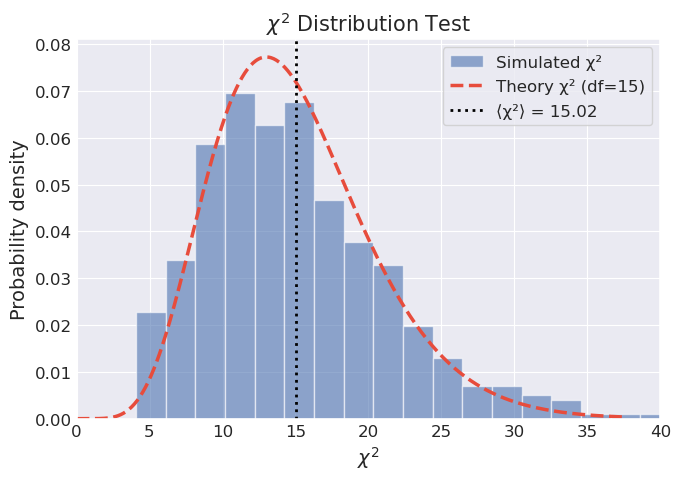

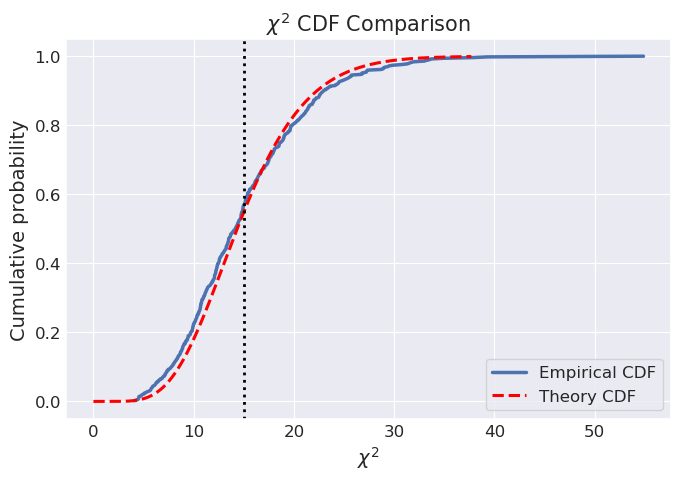

<χ²> = 15.02 (expected 15.00)
Var(χ²) = 42.01 (expected 30.00)
PTE = 0.450


In [21]:
chi2_vals = check_chi2_HL(data, r=0, AL=1, lmin=0, lmax=5)
test_chi2_distribution(chi2_vals, p=3*(5-0), bins=25)

##  χ² after fitting

In [23]:
import numpy as np
from scipy.optimize import minimize



def chi2_r_AL(params, data_obs, lmin=0, lmax=5):
    """
    Calculates the chi2 value for given r and AL. HL likelihood.
    """

    r, AL = params

    # Theoretical Cl -> Theoretical binned prediction, keep the same format as before
    th_vec = split_th_vec(get_cl(r,AL,lmax))
    C_theory = matrix_vec2C(list(th_vec.values()), tri='lower')
    # X_theory expected shape = (nspec, nbins), e.g. (3, 5)

    Chat = matrix_vec2C(data_obs, tri='lower')
    Cfhalf = matrix_sqrt(Chat)
    C_mo = get_Cgl(C_theory[:,:,:lmax], Chat[:,:,:lmax], Cfhalf[:,:,:lmax], lmax)
    #C_mo = np.nan_to_num(C_mo, nan=0.0)
    X_g = (matrix_C2X(C_mo)[:,:lmax+1]).astype(np.float64)


    chi2_val = 0.0
    for i in np.arange(lmin, lmax):
        for j in np.arange(lmin, lmax):
            chi2_val += np.dot(np.dot((X_g[:,i]).T, COV_INV['({},{})'.format(i, j)] ), (X_g[:,j]))

    return chi2_val


In [22]:
def chi2_for_all_sims(data, lmin=0, lmax=5):
    Nsim = data.shape[0]
    chi2_list = []
    for s in range(Nsim):
        x0 = np.array([0.0, 1.0])

        # If you want r >= 0, you can add a simple bounds
        bounds = [(0.0, None),    # r >= 0
                (0.0, None)]      # AL >= 0

        res = minimize(
            chi2_r_AL,
            x0=x0,
            args=(data[s], lmin, lmax),
            method='L-BFGS-B',
            bounds=bounds,
        )

        r_hat, AL_hat = res.x
        chi2_min = res.fun
        if chi2_min is None or np.isnan(chi2_min):
            #print(f"Warning: Simulation {s} returned NaN chi2_min, skipping.")
            continue
        chi2_list.append(chi2_min)
    return np.array(chi2_list)


In [ ]:
ell_cond = ['full', 'diag', 'nearest']
comp_cond = ['full', 'diag', 'nearest']

i = 1
j = 0

cov_condition = covmat_condition(COV_sim, ell_flag=ell_cond[i], map_flag=comp_cond[j])
COV_INV = cov_dict_inverse(cov_condition, HA_factor)

In [370]:
# 用 (r_hat, AL_hat) 在所有模拟上算 chi2，看分布是不是接近 dof
chi2_sims = chi2_for_all_sims(data, 0, 5)

print("mean chi2 (sims)   =", chi2_sims.mean())
print("var chi2 (sims)    =", chi2_sims.var())

/tmp/ipykernel_19061/4179727324.py:27: RuntimeWarning: divide by zero encountered in divide
  A_inv_sqrt = v_A @ np.diag(1.0 / np.sqrt(w_A_reg)) @ v_A.T
/tmp/ipykernel_19061/4179727324.py:27: RuntimeWarning: invalid value encountered in matmul
  A_inv_sqrt = v_A @ np.diag(1.0 / np.sqrt(w_A_reg)) @ v_A.T


mean chi2 (sims)   = 16.157236284063988
var chi2 (sims)    = 57.63346549966295


In [24]:
def test_chi2_distribution_fitted(chi2_vals, p, xmax=40, bins=15):
    """
    Check if the fitted χ² distribution matches theoretical expectations + display PTE
    """
    mean_chi2 = np.mean(chi2_vals)
    var_chi2 = np.var(chi2_vals)
    pte = 1 - chi2.cdf(mean_chi2, df=p)

    # === 1. PDF Comparison ===
    fig, ax = plt.subplots(figsize=(7, 5))
    # Histogram
    ax.hist(
        chi2_vals, bins=bins, density=True, alpha=0.6,
        color="#B53B9B", edgecolor='white', label='Simulated χ²'
    )
    # Theoretical curve
    x = np.linspace(0, chi2.ppf(0.999, df=p), 400)
    ax.plot(x, chi2.pdf(x, df=p), color="#3CE7B7", lw=2.5,
            linestyle='--', label=f'Theory χ² (df={p})')

    # Mean χ² line
    ax.axvline(mean_chi2, color='k', lw=2, linestyle=':',
               label=f'⟨χ²⟩ = {mean_chi2:.2f}')


    ax.set_xlabel(r'$\chi^2$')
    ax.set_ylabel('Probability density')
    ax.set_title(r'Fitted $ \chi^2$ Distribution Test')
    ax.set_xlim(0, xmax)
    ax.legend(frameon=True)
    plt.tight_layout()
    plt.savefig('chi2_distribution_fitted_sum_10.pdf',dpi=300)
    plt.show()

    # === 2. CDF Comparison ===
    fig, ax = plt.subplots(figsize=(7, 5))
    sorted_vals = np.sort(chi2_vals)
    empirical_cdf = np.arange(1, len(chi2_vals) + 1) / len(chi2_vals)

    ax.plot(sorted_vals, empirical_cdf, lw=2.5,
            color="#B04CA6", label='Empirical CDF')
    ax.plot(x, chi2.cdf(x, df=p), 'r--', lw=2.2, label='Theory CDF')
    ax.axvline(mean_chi2, color='k', linestyle=':', lw=2)

    ax.set_xlabel(r'$\chi^2$')
    ax.set_ylabel('Cumulative probability')
    ax.legend(frameon=True)
    ax.set_title(r'$\chi^2$ CDF Comparison')
    plt.tight_layout()
    plt.show()

    print(f"<χ²> = {mean_chi2:.2f} (expected {p:.2f})")
    print(f"Var(χ²) = {var_chi2:.2f} (expected {2*p:.2f})")
    print(f"PTE = {pte:.3f}")

In [ ]:
test_chi2_distribution_fitted(chi2_sims, p=13, xmax=40, bins=13)   # NOTICE: dof=13 because of the fitting of (r, AL)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

# ---- DATA ----
pvals = 1 - chi2.cdf(chi2_sims, df=13)
df = 13

# ---- PLOTTING ----
fig, ax = plt.subplots(figsize=(7, 5))

# Histogram of simulated p-values
ax.hist(
    pvals, bins=12, density=True, alpha=0.65,
    color="#2CC24A", edgecolor="white",
    label="Simulated p-values"
)

# Theoretical uniform distribution curve (p-values ~ Uniform[0, 1])
x = np.linspace(0, 1, 200)
ax.plot(x, np.ones_like(x), lw=2.4, linestyle="--", color="darkorange",
        label="Expected uniform distribution")

# Mark mean p-value
mean_p = np.mean(pvals)
ax.axvline(mean_p, color='black', lw=2, linestyle=':',
           label=r'$\langle p \rangle = %.2f$' % mean_p)

# ---- STYLING ----
ax.set_xlabel(r"$p$-value", fontsize=13)
ax.set_ylabel("Probability density", fontsize=13)
ax.set_title(r"Distribution of $p$-values (df = %d)" % df, fontsize=15)

# Axis limits & grid
ax.set_xlim(0, 1)
ax.set_ylim(0, 2)
plt.tight_layout()
#ax.grid(alpha=0.25, linestyle=":")

# Legend
ax.legend(frameon=True, fontsize=18)

plt.tight_layout()
#plt.savefig("p_value_distribution_uniform_check_sum_10.pdf", dpi=300)
plt.show()


## Local chi2 

In [ ]:
ell_cond = ['full', 'diag', 'nearest']
comp_cond = ['full', 'diag', 'nearest']

i = 1
j = 0

cov_condition = covmat_condition(COV_sim, ell_flag=ell_cond[i], map_flag=comp_cond[j])
COV_INV = cov_dict_inverse(cov_condition, HA_factor)

/home/chen/Testarea/A_NEW_WORK_MAIN_revise/plot_for_paper3/test_covmat_consitioing/HL_likelihood.py:626: ComplexWarning: Casting complex values to real discards the imaginary part
  matrix_root[:, :, i] = sqrtm(matrix[:, :, i])


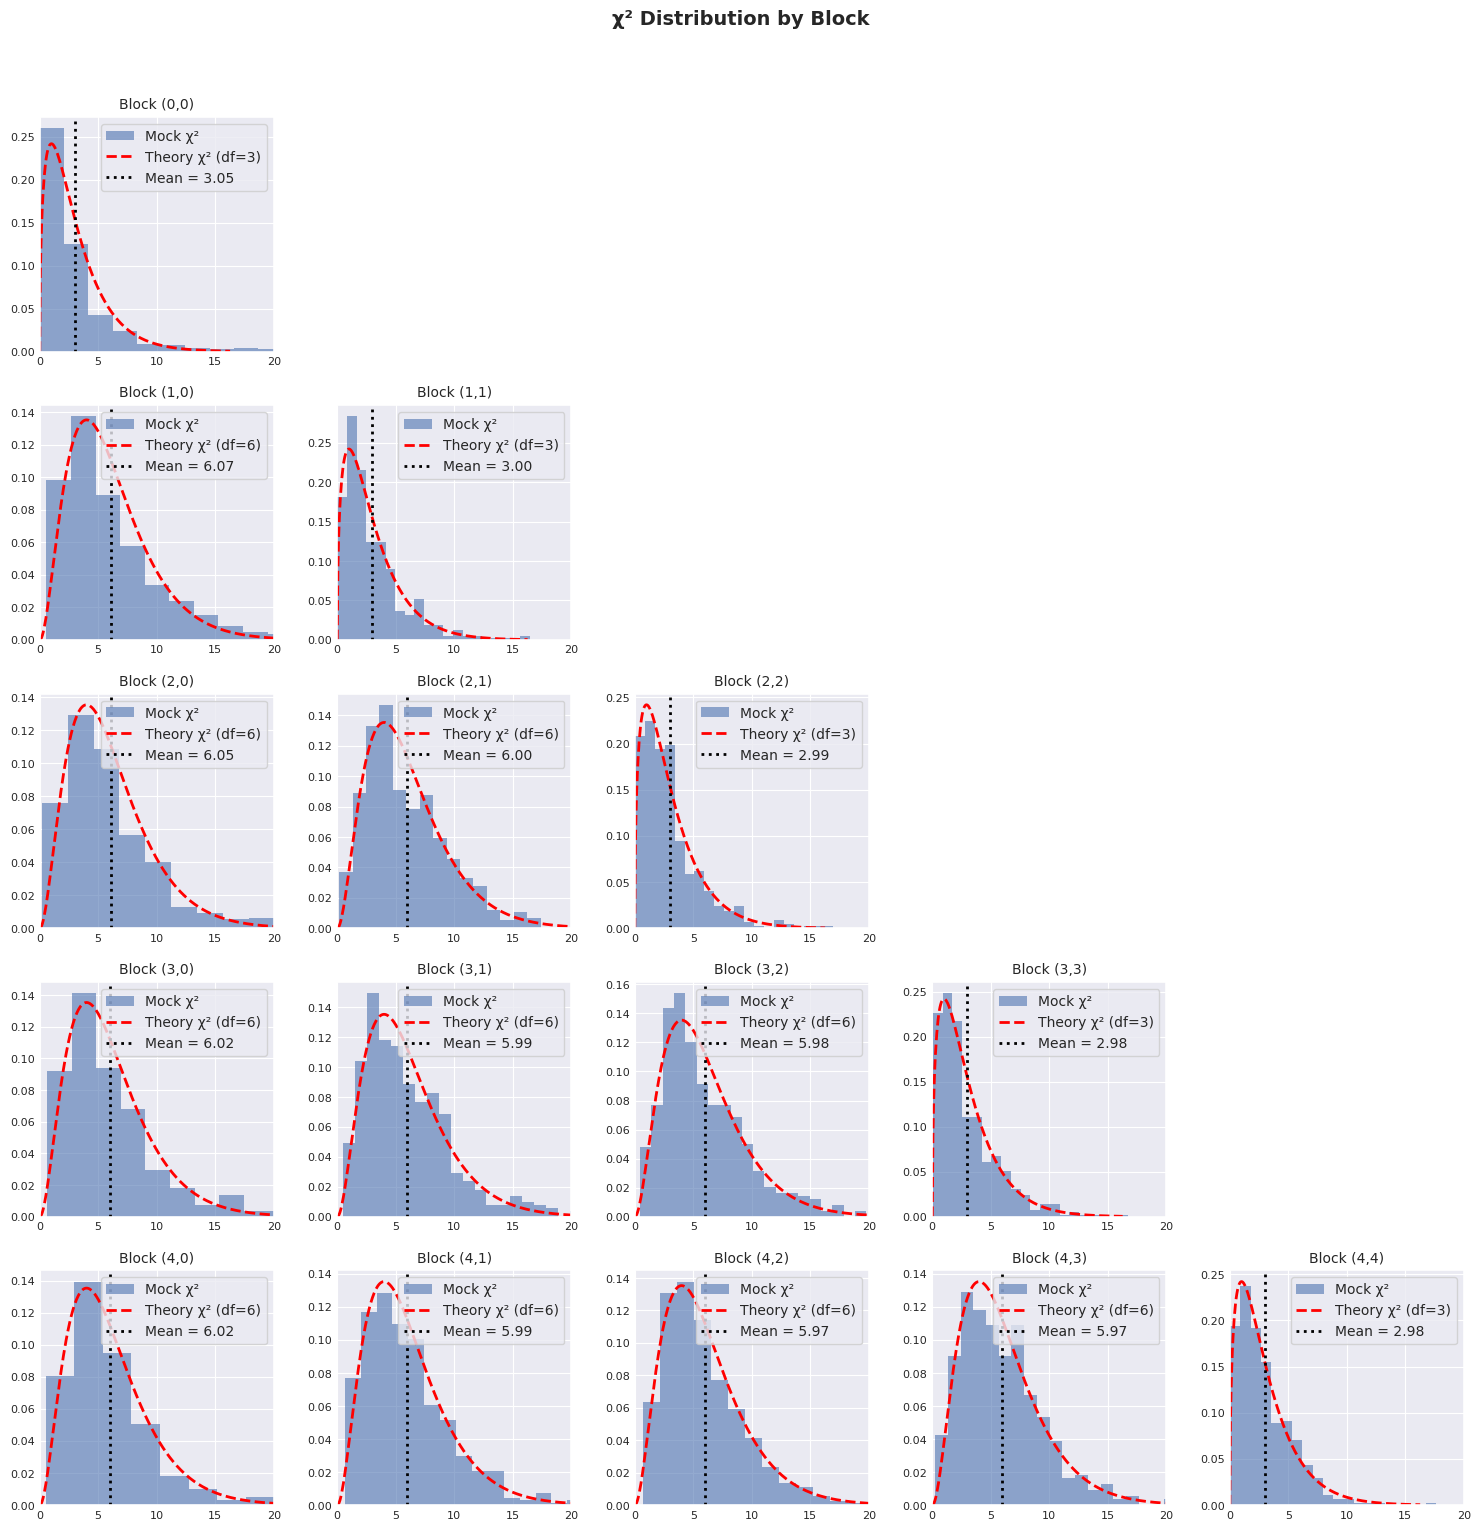

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

def plot_block_chi2_triangle(data, COV, lmin=0, lmax=7):
    """
    Plot χ² distributions for each covariance block in a triangle layout.
    """
    Nsim = np.shape(data)[0]
    Ncomp = data.shape[1]
    n_bins = lmax - lmin

    fig, axes = plt.subplots(n_bins, n_bins, figsize=(3*n_bins, 3*n_bins))
    plt.subplots_adjust(wspace=0.25, hspace=0.25)

    for i in range(lmin, lmax):
        for j in range(lmin, lmax):
            ax = axes[i-lmin, j-lmin]

            # Only plot lower triangle
            if i < j:
                ax.axis("off")
                continue

            key = f"({i},{j})"
            if key not in COV:
                ax.text(0.5, 0.5, "Missing", ha="center", va="center", fontsize=9)
                ax.axis("off")
                continue

            # === Construct COV block ===
            if i == j:
                cov_block = COV[key]
                cov_inv = np.linalg.inv(cov_block)
                df = Ncomp
                chi2_block = [
                    (data[s][:, i] ).T @ cov_inv @ (data[s][:, i] )
                    for s in range(Nsim)
                ]
            else:
                block = np.block([
                    [COV[f"({i},{i})"], COV[f"({i},{j})"]],
                    [COV[f"({j},{i})"], COV[f"({j},{j})"]]
                ])
                cov_inv = np.linalg.inv(block)
                df = 2 * Ncomp
                chi2_block = [
                    np.concatenate([data[s][:, i] ,
                                    data[s][:, j] ]).T
                    @ cov_inv @
                    np.concatenate([data[s][:, i] ,
                                    data[s][:, j] ])
                    for s in range(Nsim)
                ]

            chi2_block = np.array(chi2_block)
            chi2_block = np.delete(chi2_block, np.where(np.isnan(chi2_block)))
            chi2_mean = np.mean(chi2_block)
            pte = 1 - chi2.cdf(chi2_mean, df=df)

            # === Plot ===
            x = np.linspace(0, chi2.ppf(0.999, df=df), 300)
            ax.hist(chi2_block, bins=20, density=True, alpha=0.6, color="#4C72B0", label="Mock χ²")
            ax.plot(x, chi2.pdf(x, df=df), "r--", lw=2, label=f"Theory χ² (df={df})")
            ax.axvline(chi2_mean, color="k", linestyle=":", lw=2, label=f"Mean = {chi2_mean:.2f}")


            ax.set_title(f"Block ({i},{j})", fontsize=10)
            ax.tick_params(axis="both", labelsize=8)
            ax.legend(fontsize=10, loc="upper right", frameon=True)
            ax.set_xlim(0,20)

    fig.suptitle("χ² Distribution by Block", fontsize=14, weight="bold", y=1.02)
    plt.tight_layout()
    plt.savefig('chi2_distribution_bins_20.pdf',dpi=300)
    plt.show()



th_vec = split_th_vec(get_cl(r=0,AL=1))
C_theory = matrix_vec2C(list(th_vec.values()), tri='lower')


X_g_all = []
for sim_index in range(Nsim):
    lmax=5
    Chat = matrix_vec2C(data[sim_index], tri='lower')
    Cfhalf = matrix_sqrt(Chat)
    C_mo = get_Cgl(C_theory[:,:,:lmax], Chat[:,:,:lmax], Cfhalf[:,:,:lmax], lmax)
    #C_mo = np.nan_to_num(C_mo, nan=0.0)
    X_g = (matrix_C2X(C_mo)[:,:lmax+1]).astype(np.float64)
    X_g_all.append(X_g)
X_g_all = np.array(X_g_all)

plot_block_chi2_triangle(X_g_all, cov_condition, lmin=0, lmax=5)



In [287]:
np.shape(C_theory)

(2, 2, 10)

## positive definiteness check

In [ ]:
import numpy as np

def check_covmat_positive_definite(COV, verbose=True):
    """
    check each block and nearest-neighbor blocks of the covariance matrix for positive definiteness.

    参数:
      COV : dict
          Dictionary with keys like COV["(i,j)"] = block_matrix (3x3 or 6x6 etc.)
          Assumes the matrix is symmetric (COV["(j,i)"] = COV["(i,j)"].T)

    Returns:
      results : dict
          Minimum eigenvalue and positive definiteness flag for each (i,i) block.
    """
    results = {}
    keys = list(COV.keys())
    # Estimate number of bins
    all_bins = sorted(set(int(k.split(',')[0][1:]) for k in keys))
    nbin = len(all_bins)
    Ncomp = list(COV.values())[0].shape[0]

    for i in range(nbin):
        # === Diagonal blocks ===
        if f"({i},{i})" in COV:
            block = COV[f"({i},{i})"]
            block_sym = 0.5 * (block + block.T)
            eigvals = np.linalg.eigvalsh(block_sym)
            results[(i, i)] = {"min_eig": np.min(eigvals), "is_PD": np.all(eigvals > 0)}

            if verbose:
                status = "✅ PD" if np.all(eigvals > 0) else "❌ Not PD"
                print(f"Block ({i},{i}): min eigen = {np.min(eigvals):.3e}  -->  {status}")

        # === Nearest-neighbor blocks ===
        if i < nbin - 1 and f"({i},{i+1})" in COV:
            try:
                block_ii = COV[f"({i},{i})"]
                block_ij = COV[f"({i},{i+1})"]
                block_jj = COV[f"({i+1},{i+1})"]

                block_pair = np.block([
                    [block_ii, block_ij],
                    [block_ij.T, block_jj]
                ])
                block_pair_sym = 0.5 * (block_pair + block_pair.T)
                eigvals = np.linalg.eigvalsh(block_pair_sym)
                results[(i, i+1)] = {"min_eig": np.min(eigvals), "is_PD": np.all(eigvals > 0)}

                if verbose:
                    status = "✅ PD" if np.all(eigvals > 0) else "❌ Not PD"
                    print(f"Block ({i},{i+1}): min eigen = {np.min(eigvals):.3e}  -->  {status}")
            except Exception as e:
                print(f"⚠️ Error forming block ({i},{i+1}): {e}")

    # Check global matrix positive definiteness
    try:
        # Assemble full matrix (assuming each block is 3x3)
        nbin = int(np.sqrt(len(COV)))  # Estimate number of bins
        Ncomp = list(COV.values())[0].shape[0]
        full_cov = np.zeros((nbin*Ncomp, nbin*Ncomp))

        for i in range(nbin):
            for j in range(nbin):
                key = f"({i},{j})"
                if key in COV:
                    full_cov[i*Ncomp:(i+1)*Ncomp, j*Ncomp:(j+1)*Ncomp] = COV[key]

        full_cov_sym = 0.5 * (full_cov + full_cov.T)
        eigvals = np.linalg.eigvalsh(full_cov_sym)
        min_eig = np.min(eigvals)
        pos_def = np.all(eigvals > 0)
        print(f"\nGlobal covariance matrix: min eigenvalue = {min_eig:.3e}  -->  {'✅ PD' if pos_def else '❌ Not PD'}")

    except Exception as e:
        print(f"\n⚠️ Unable to assemble global matrix: {e}")

    return results


results = check_covmat_positive_definite(cov_condition)

Block (0,0): min eigen = 1.079e-10  -->  ✅ PD
Block (0,1): min eigen = 1.079e-10  -->  ✅ PD
Block (1,1): min eigen = 7.668e-10  -->  ✅ PD
Block (1,2): min eigen = 7.668e-10  -->  ✅ PD
Block (2,2): min eigen = 2.993e-09  -->  ✅ PD
Block (2,3): min eigen = 2.993e-09  -->  ✅ PD
Block (3,3): min eigen = 8.894e-09  -->  ✅ PD
Block (3,4): min eigen = 8.894e-09  -->  ✅ PD
Block (4,4): min eigen = 2.005e-08  -->  ✅ PD

Global covariance matrix: min eigenvalue = 1.079e-10  -->  ✅ PD


# Below are the MCMC fitting part

## Gaussian Likelihood

In [ ]:
data_vec = np.loadtxt('./post_cal/data_vec_fit_average_old.txt')

In [36]:
def gauss_cl_logp_full(r, AL, lmin=1, lmax=5,):
    """
    Defines a gaussian likelihood in log.
    """
    likelihood = 0
    X_theory = np.array(list(split_th_vec(get_cl(r,AL,lmax)).values()))
    for i in np.arange(lmin,lmax):
        for j in np.arange(lmin,lmax):
            likelihood_l = np.dot(np.dot((data_vec[:,i] - X_theory[:,i]).T, COV_INV['({},{})'.format(i, j)] ), (data_vec[:,j] - X_theory[:,j])) #+ COV_DET[i]
            #likelihood_l = np.dot(np.dot((X_data[:,i] - X_theory[:,i]).T, cli(cal_cov_3(X_data,l[i],fsky=0.8,)[:,:,i])), (X_data[:,i] - X_theory[:,i])) 
            likelihood += -0.5*likelihood_l
    return likelihood

In [37]:
a = gauss_cl_logp_full(r=0, AL=1, )
a

-0.013220471824130341

## Hamimeche-Lewis Likelihood

In [ ]:
data_vec = np.loadtxt('./post_cal/data_vec_fit_average_old.txt')


Chat = matrix_vec2C(data_vec, tri='lower')
Cfhalf = matrix_sqrt(Chat)

In [47]:
def HL_logp_full(r, AL, lmin=0, lmax=5):
    """
    Defines the HL likelihood in log.
    """
    likelihood = 0
    th_vec = split_th_vec(get_cl(r,AL,lmax))
    C_theory = matrix_vec2C(list(th_vec.values()), tri='lower')
    #C_theory = np.array([val + 0j for val in C_theory])

    #Cfhalf = matrix_sqrt(C_theory)

    #C_mo = transform0(C_theory[:,:,:lmax], Chat[:,:,:lmax], Cfhalf[:,:,:lmax], lmax)
    C_mo = get_Cgl(C_theory[:,:,:lmax], Chat[:,:,:lmax], Cfhalf[:,:,:lmax], lmax)
    #C_mo = np.nan_to_num(C_mo, nan=0.0)
    X_g = (matrix_C2X(C_mo)[:,:lmax+1]).astype(np.float64)

    
    for i in np.arange(lmin,lmax):
        for j in np.arange(lmin,lmax):
            if 1:
                likelihood_l = np.dot(np.dot((X_g[:,i]).T, COV_INV['({},{})'.format(i, j)] ), (X_g[:,j])) #+ COV_DET[i]
                #likelihood_l = np.dot(np.dot((X_data[:,i] - X_theory[:,i]).T, cli(cal_cov_3(X_data,l[i],fsky=0.8,)[:,:,i])), (X_data[:,i] - X_theory[:,i])) 
                likelihood += -0.5*likelihood_l
    return likelihood

In [48]:
b = HL_logp_full(r=0, AL=1)
b

-0.021685222384814802

## Sellentin-Heavens Likelihood

In [41]:
def SH_logp_full(r, AL, lmin=0, lmax=5, N_sims=499):
    """
    Sellentin & Heavens (2016) t-distribution likelihood in log form.
    
    Parameters
    ----------
    r, AL : float
        Model parameters.
    N_sims : int
        Number of simulations used to estimate the covariance matrix.
    lmin, lmax : int
        Range of multipole bins.
    """
    likelihood = 0
    X_theory = np.array(list(split_th_vec(get_cl(r, AL, lmax)).values()))
    
    # Loop over all block pairs
    for i in np.arange(lmin, lmax):
        for j in np.arange(lmin, lmax):
            diff_i = data_vec[:, i] - X_theory[:, i]
            diff_j = data_vec[:, j] - X_theory[:, j]
            Q_ij = np.dot(np.dot(diff_i.T, COV_INV['({},{})'.format(i, j)]), diff_j)
            likelihood += Q_ij  # accumulate total quadratic form
    
    # Apply the Sellentin–Heavens correction
    lnL = -0.5 * N_sims * np.log(1 + likelihood / (N_sims - 1))
    
    return lnL


In [42]:
c = SH_logp_full(r=0, AL=1)
c

-0.022299070897037154

##  ############################ Here we go##################################

In [49]:
#info = {"likelihood": {"r&AL": SH_logp_full}}

info = {"likelihood": {"r&AL": HL_logp_full}}

#info = {"likelihood": {"r&AL": gauss_cl_logp_full}}

In [50]:
info["params"] = {
    #"H0": {"prior": {"min": 66.9, "max": 67.1}, "ref": 67, "proposal": 0.001, "latex": r"H_0"},
    #"ns": {"prior": {"min": 0.94, "max": 0.98}, "ref": 0.96, "proposal": 0.001, "latex": r"n_s"},
    "r": {"prior": {"min": -0.1, "max": 0.1}, "ref": 0, "proposal": 0.00001, "latex": r"r"},
    "AL": {"prior": {"min": 0.8, "max": 1.2}, "ref": 1, "proposal": 0.001, "latex": r"r"},
}

In [ ]:
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

import logging
logging.getLogger("mcmc").setLevel(logging.ERROR)

In [ ]:
##########################  Choose covariance condition  ##########################

ell_cond = ['full', 'diag', 'nearest']
comp_cond = ['full', 'diag', 'nearest']

m = 1
n = 0

cov_condition = covmat_condition(COV_sim, ell_flag=ell_cond[m], map_flag=comp_cond[n])
COV_INV = cov_dict_inverse(cov_condition, HA_factor)

In [57]:
info["sampler"] = {"mcmc": {"Rminus1_stop": 1e-4, 
                            "max_tries": 1000000000, 

}}

from cobaya import run
updated_info, sampler = run(info)

[parameterization] *WARNING* There are repeated parameter labels: {'r': ['r', 'AL']}


INFO:r&al:Initialized external likelihood.


[r&al] Initialized external likelihood.


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {r&AL: 2880.0}


[model] Setting measured speeds (per sec): {r&AL: 2880.0}


Mean:
[-3.55975567e-06  1.00117025e+00  2.02849099e+00  2.02849099e+00]
Standard error:
[[0.00045394        nan]
 [       nan 0.01528173]]


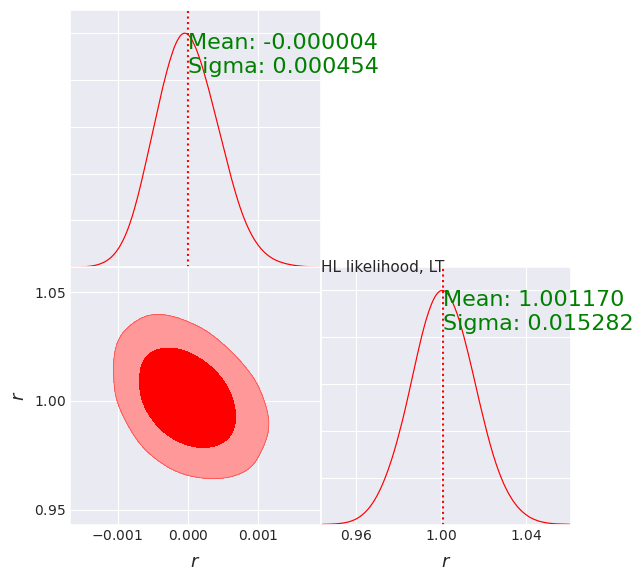

In [58]:
# Export the results to GetDist
gd_sample2 = sampler.products(skip_samples=0.3,to_getdist=True)["sample"]

# Analyze and plot
mean = gd_sample2.getMeans()[:8]
covmat = gd_sample2.getCovMat().matrix[:8, :8]
print("Mean:")
print(mean)
print("Standard error:")
print(np.sqrt(covmat))
# %matplotlib inline  # uncomment if running from the Jupyter notebook
import getdist.plots as gdplt

gdplot = gdplt.get_subplot_plotter(subplot_size=3.0) 
gdplot.triangle_plot(gd_sample2, ["r","AL",], filled=True, contour_colors=['red'])  #"r","A_d","alpha_d","beta_d","A_s","alpha_s","beta_s"


for i in range(2):
    gdplot.subplots[i, i].axvline(x=mean[i], color='r', linestyle=':')
    gdplot.subplots[i, i].text(mean[i], 1, f"Mean: {mean[i]:.6f}", fontsize=16, color='green', ha='left', va='top')
    gdplot.subplots[i, i].text(mean[i], 0.9, f"Sigma: {np.sqrt(covmat[i])[i]:.6f}", fontsize=16, color='green', ha='left', va='top')
    #gdplot.subplots[i, i].set_xlim(0, 1)

gdplot.add_text("HL likelihood, LT ", x=0, y=1)


# Gather and combine the chains from all MPI processes, skipping the first third of each chain
full_chain = sampler.samples(combined=True, skip_samples=0.3, to_getdist=True)


with open(f'./chains/temp_HL_{ell_cond[m]}_{comp_cond[n]}.pkl', 'wb') as f:
     pickle.dump(gd_sample2, f)